# Machine Learning Assignment 3

## Neural Network created for the Wine dataset 
#### Wine dataset has 14 attributes and 178 rows of the observations. In this current state we are not performing any dimensionality reduction, no multiple hidden layers 

/Library/Python/2.7/site-packages/ipykernel/__main__.py:195: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


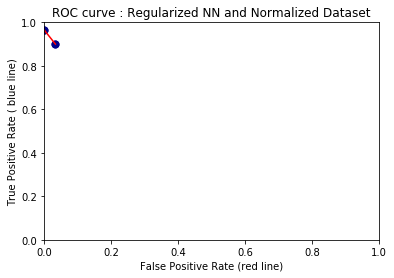

Accuracy of the Model is 96.629
Jobs Ends!!


In [13]:
from math import exp
from random import seed
import random
from random import randrange
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import time
from matplotlib import pyplot as plt

''' Initialize the network '''
def init_network(numinputs, numhiddenlayer, numoutputs):
    net=list()
    # hidden layer
    #np.random.uniform()
    HiddenLayer = [{'weights':[0 for i in range(numinputs+1)]} for i in range(numhiddenlayer)]
    net.append(HiddenLayer)
    OutputLayer = [{'weights':[0 for i in range(numhiddenlayer+1)]} for i in range(numoutputs)]
    net.append(OutputLayer)
    return net

''' Transfer activation function for the neuron '''

def transferFunction(actn):
    return 1.0/(1.0+exp(-actn))

'''Calculation of activation of neuron from an input '''

def activateFunction(wts, inp):
    activaN = wts[-1]
    for i in range(len(wts)-1):
        activaN+=wts[i]*inp[i]
    return activaN

''' Forward Propagation of the network '''

def forwardPropagationNet(netK, row):
    inps = row
    for layer in netK:
        newinps=[]
        for neuron in layer:
            activaN = activateFunction(neuron['weights'], inps)
            neuron['output'] = transferFunction(activaN)
            newinps.append(neuron['output'])
        inps = newinps
    return inps, neuron['weights']


''' Derivative of the Transfer Function '''
def derivativeTransferFunction(op):
    return (op)*(1-op)

''' Backward Propagation of the network '''

def backwardPropagationNet(netK, observed):
    for i in reversed(range(len(netK))):
        layer = netK[i]
        errorlst = list()
        if i != len(netK)-1:
            for j in range(len(layer)):
                e = 0.0
                for neuron in netK[i+1]:
                    e += (neuron['weights'][j] * neuron['delta'])
                errorlst.append(e)
        else:
            for k in range(len(layer)):
                neuron = layer[k]
                errorlst.append(observed[k] - neuron['output'])
        for p in range(len(layer)):
            neuron = layer[p]
            neuron['delta'] = errorlst[p] * derivativeTransferFunction(neuron['output'])


''' Update Weights of the Network '''
def updateWeightsFunction(netK, row, learningRate):
    for i in range(len(netK)):
        inp = row[:-1]
        if i != 0:
            inp = [neuron['output'] for neuron in netK[i-1]]
        for neuron in netK[i]:
            for j in range(len(inp)):
                neuron['weights'][j] += learningRate * neuron['delta'] * inp[j]
            neuron['weights'][-1] += learningRate * neuron['delta']


''' Training the Network.'''

def trainingNetwork(netK, trainData, learningRate, epochs, numoutputs):
    #print("Learning Rate of the network = %.3f" % (learningRate))
    #epocherror = 0
    reg_lambda = 0.0001
    for epoch in range(epochs):
        errorsum = 0
        for row in trainData:
            outputs, weights = forwardPropagationNet(netK,row)
            #print weights
            #print np.sum(np.square(weights))
            #raise KeyboardInterrupt
            observed = [0 for i in range(numoutputs)]
            #print len(observed)
            #print observed
            #print row[-1]
            #raise KeyboardInterrupt
            observed[int(row[-1])] = 1
            errorsum -= sum([(observed[i]-outputs[i])**2 for i in range(len(observed))])
            errorsum += reg_lambda/float(2)*np.sum(np.square(weights))
            backwardPropagationNet(netK,observed)
            updateWeightsFunction(netK,row,learningRate)
        #print('Number_of_Epoch=%d, trainingError=%.3f' % (epoch,errorsum))
        #epocherror=errorsum
    #print("Training Accuracy of the Model after Training is %.3f" % (100+epocherror))


''' Cross Validation function '''
def splitByCrossValidation(data,nFolds):
    dataSplit = list()
    copyData = data
    foldNumber = int(len(data) / nFolds)
    for i in range(nFolds):
        fold = list()
        while len(fold) < foldNumber :
            idx = randrange(len(copyData))
            fold.append(copyData.pop(idx))
        dataSplit.append(fold)
    return dataSplit

''' Prediction Function '''
def predict(netK,row):
    out,_ = forwardPropagationNet(netK,row)
    out = [round(a,1) for a in out]
    #print "out", out
    return out.index(max(out))

''' Accuracy Metric '''

def accuracyCalculation(A,P):
    hit = 0
    for i in range(len(P)):
        if A[i] == P[i]:
            hit+=1
    return (hit/float(len(A))) * 100.0

def printPR(tp,P,A,fn,fp,label):
    precision=0; recall=0
    #print "tp:", tp
    try:
        precision = tp/float(len(P))
    except ZeroDivisionError:
        print "error"
    try:
        #print "Actual count :", A.count(label)
        assert fn >= 0
        recall = float((float(tp)/float(tp+fn)))#float(A.count(label))
    except ZeroDivisionError:
        print "error"
    print precision, recall#, fp/float(fp+tn)
    return
    
def confusionmatrix(A,P,label):
    tp=0; fp=0; tn=0; fn=0;
    for i in range(len(A)):
        if int(A[i]) == P[i]:
            if int(A[i]) == label:
                tp+=1
            else:
                tn+=1
        else:
            if int(A[i]) == label:
                fn+=1
            if P[i] == label:
                fp+=1
    return tp, tn, fp, fn
    #printPR(tp,P,A,fn,fp,label)

def normlize_dataframe(df):
    '''

    :param df:
    :return: normalized dataframe after Min-max feature scaling (normalization)
    '''
    df_norm = (df - df.min()) / (df.max()-df.min())
    return df_norm

def someplots(df):
    print(df.groupby('Class').size())
    plt.figure(figsize=(50, 50))
    df.plot(kind='box', subplots=True, layout=(2,7), sharex=False, sharey=False)
    plt.show()
    df.hist()
    plt.show()

def plot_roc(df):
    lw = 2
    df = df.sort(['fpr'])
    plt.scatter(df.fpr, df.tpr, color='darkblue',
             lw=lw)#, #label='ROC curve (area = %0.2f)' % roc_auc[2])
    z = np.polyfit(df.fpr, df.tpr, 1)
    p = np.poly1d(z)
    plt.plot(df.fpr,p(df.fpr),"r-")
    plt.plot(df.tpr, p(df.tpr), 'b-')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (red line)')
    plt.ylabel('True Positive Rate ( blue line)')
    plt.title('ROC curve : Regularized NN and Normalized Dataset')
    #plt.legend(loc="lower right")
    plt.show()
    return    

    
''' Main Function '''

if __name__ == '__main__':
    seed(1)
    df = pd.read_csv('../datasets/wine.csv')
    df = shuffle(df)
    #someplots(df)
    #raise KeyboardInterrupt
    newdf = df.copy(deep=True)
    cols_list = df.columns.values
    ''' following columns are to be removed'''
    #newdf = newdf.drop(cols_list[1], 1)
    #newdf = newdf.drop(cols_list[2], 1)
    #newdf = newdf.drop(cols_list[3], 1)
    #newdf = newdf.drop(cols_list[4], 1)
    #newdf = newdf.drop(cols_list[8], 1)
    #newdf = newdf.drop(cols_list[9], 1)
    #newdf = newdf.drop(cols_list[12], 1)
    '''**************************************'''
    newdf.Class = newdf.Class.replace(1,1)
    newdf.Class = newdf.Class.replace(2,0)
    newdf.Class = newdf.Class.replace(3,0)
    TP0 = 0; TN0 = 0; FP0=0; FN0=0;
    TP1 = 0; TN1 = 0; FP1=0; FN1=0;
    newdf = normlize_dataframe(newdf)
    #print newdf.head()
    #raise KeyboardInterrupt
    newdf = newdf.sample(frac=1).reset_index(drop=True)
    #print newdf.shape
    #print df.shape
    #raise KeyboardInterrupt
    #print('Data Loaded and Prepared.')
    dataset=list()
    for rows in newdf.values:
        dataset.append(list(rows))
    #print np.asarray(dataset).shape
    #raise KeyboardInterrupt
    numFolds = 7
    #print('Now we are performing CrossValidation')
    dataSplit = splitByCrossValidation(dataset,numFolds)
    resultscore = list()
    trainset=list()
    testset=list()
    tpr_list = list(); fpr_list=list()
    for fld in dataSplit:
        for itr in range(20):
            trainset = list(dataSplit)
            trainset.remove(fld)
            #raise KeyboardInterrupt
            #print trainset.remove(fld)
            trainset = sum(trainset,[])
            testset =list()
            for r in fld:
                copyrow = list(r)
                testset.append(copyrow)
                copyrow[-1] = None
            numinputs = len(trainset[0])-1
            #print("Number of the features of the dataset %d" %(numinputs))
            numoutputs = len(set(row[-1] for row in trainset))
            #print("Number of the labels of the dataset %d" %(numoutputs))
            #print("Initializing the Network .......")
            ''' Passing the number of features, number of hidden neurons and number of outputs'''
            netK = init_network(numinputs,3,numoutputs)
            #print("Network Initialized. Training of the Network, begins ....")
            ''' Passing data, network, learning rate, epochs and number of outputs'''
            trainingNetwork(netK, trainset, 0.01, 600, numoutputs)
            #print('Printing the output of each layer of the network')
            #for layer in netK:
             #   print(layer)
            predictions = list()
            for row in testset:
                pred = predict(netK, row)
                predictions.append(pred)
            actualval = [row[-1] for row in fld]
            result= accuracyCalculation(actualval,predictions)
            tp0, tn0, fp0, fn0 = confusionmatrix(actualval, predictions, 0)
            tp1, tn1, fp1, fn1 = confusionmatrix(actualval, predictions, 1)
            tpr_list.append((tp1)/float(tp1+fn1)); fpr_list.append(fp1/float(fp1+tn1))
            resultscore.append(result)
    ROC_data = pd.DataFrame({'tpr': tpr_list, 'fpr': fpr_list})
    plot_roc(ROC_data)
    print("Accuracy of the Model is %.3f" %(sum(resultscore)/float(len(resultscore))))
    print('Jobs Ends!!')